# Анализ бизнес показателей приложения Procrastinate Pro+ #

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. <br>
Наша задача — разобраться в причинах и помочь компании выйти в плюс. <br>
<br>
В нашем распоряжении есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
<br>
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

<br>
Мы будем изучать:
<br>

* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

## Шаг 1. Загрузим данные и подготовим их к анализу.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

### 1.1. Положим данные о визитах, заказах и рекламных тратах в переменные.

In [ ]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
)

### 1.2. Подготовим данные к анализу. Убедимся, что тип данных во всех колонках соответствует значениям. Проверим наличие дубликатов.

In [ ]:
for df in visits, orders, costs:
    df.info()
    print('duplicated sum:', df.duplicated().sum())
    print('---------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
duplicated sum: 0
---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
duplicated sum: 0
--------------------------------

#### Пояснение
Приведем названия колонок в змеиный регистр, переведем в формат даты нужные столбцы.

In [ ]:
visits.rename(columns = {
    'User Id' : 'user_id', 'Region' : 'region', 'Device' : 'device', 'Channel' : 'channel',
    'Session Start' : 'session_start', 'Session End' : 'session_end'
}, inplace = True)
orders.rename(columns = {
    'User Id' : 'user_id', 'Event Dt' : 'event_dt', 'Revenue' : 'revenue'
}, inplace = True)
costs.rename(columns = {'Channel': 'channel'}, inplace=True)

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [ ]:
costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


## Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии

In [ ]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Шаг 3. Проведем исследовательский анализ данных

### 3.1. Создадим пользовательские профили. Определим минимальную и максимальную даты привлечения пользователей.

In [ ]:
profiles = get_profiles(sessions=visits, orders=orders, ad_costs=costs)

print('Первая дата привлечения пользователей:', profiles['first_ts'].min())
print('Последняя дата привлечения пользователей:', profiles['first_ts'].max())

Первая дата привлечения пользователей: 2019-05-01 00:00:41
Последняя дата привлечения пользователей: 2019-10-27 23:59:04


### 3.2. Построим таблицы, отражающие количество пользователей и долю платящих из каждой: страны, устройства, канала привлечения.

In [ ]:
for dimensions in ['region', 'device', 'channel']:
    print(
        profiles.groupby(dimensions)
                .agg({'user_id':'nunique', 'payer':'mean'})
                .rename(columns={'user_id':'total_user', 'payer':'share_of_paying'})
                .sort_values('share_of_paying', ascending=False)
    )
    print('-----------------------------------------------')

               total_user  share_of_paying
region                                    
United States      100002         0.069019
Germany             14981         0.041119
UK                  17575         0.039829
France              17450         0.037994
-----------------------------------------------
         total_user  share_of_paying
device                              
Mac           30042         0.063644
iPhone        54479         0.062079
Android       35032         0.058518
PC            30455         0.050468
-----------------------------------------------
                    total_user  share_of_paying
channel                                        
FaceBoom                 29144         0.122049
AdNonSense                3880         0.113402
lambdaMediaAds            2149         0.104700
TipTop                   19561         0.096007
RocketSuperAds            4448         0.079137
WahooNetBanner            8553         0.052964
YRabbit                   4312         0

#### Промежуточные выводы:
* Больше всего пользователей в США, так же самая большая доля платящих пользователей приходится на США.
* Больше всего пользователей пользуются iPhone, но самая большая доля платящих пользователей приходится Mac.
* Больше всего пользователей пришли сами "organic", самая большая доля платящих пользователей из канала FaceBoom.

## Шаг 4. Маркетинг

### 4.1. Посчитаем общую сумму расходов на маркетинг.  

In [ ]:
costs['channel'].value_counts()

YRabbit               180
TipTop                180
MediaTornado          180
OppleCreativeMedia    180
LeapBob               180
FaceBoom              180
lambdaMediaAds        180
RocketSuperAds        180
WahooNetBanner        180
AdNonSense            180
Name: channel, dtype: int64

In [ ]:
print(f'Общая сумма расходов на маркетинг: {costs["costs"].sum():.2f}')

Общая сумма расходов на маркетинг: 105497.30


#### Выясним, как траты распределены по источникам.

In [ ]:
costs.groupby('channel').agg('sum').sort_values('costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


#### 4.1.2. Визуализируем изменения метрик во времени

<AxesSubplot:xlabel='date', ylabel='costs'>

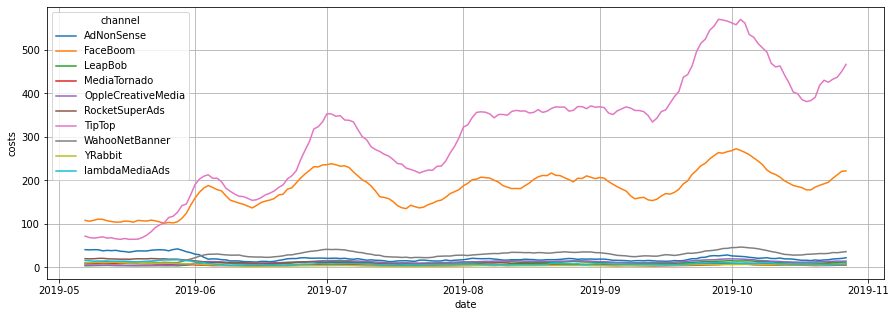

In [ ]:
filter_data(
    costs.pivot_table(
        index='dt',
        columns='channel',
        values='costs',
        aggfunc='sum'
    ), 7).plot(grid=True, figsize=(15, 5), xlabel='date', ylabel='costs')

#### Промежуточные выводы:
* Общая сумма расходов на маркетинг: 105 497.
* TipTop и FaceBoom занимают больше 80% всех расходов на рекламу.
* С мая по ноябрь траты на рекламу TipTop и FaceBoom увеличились в 5 раз.

### 4.2. Рассчитаем средний CAC на одного пользователя для всего проекта.

In [ ]:
print(f'Средняя стоимость привлечения пользователя по всем источникам: {profiles["acquisition_cost"].mean():.3f}')

Средняя стоимость привлечения пользователя по всем источникам: 0.703


#### 4.2.1. Рассчитаем средний CAC для каждого источника трафика.


In [ ]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values('acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


#### Промежуточные выводы:
* Средняя стоимость привлечения пользователя по всем источникам: 0.703
* Самая высокая стоимость привлечения у TipTop - 2,8. На втором месте FaceBoom - 1,1, на третьем AdNonSense - 1.

## Шаг 5. Оцените окупаемость рекламы


На календаре 1 ноября 2019 года. <dr>
    
В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [ ]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

### 5.1. Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

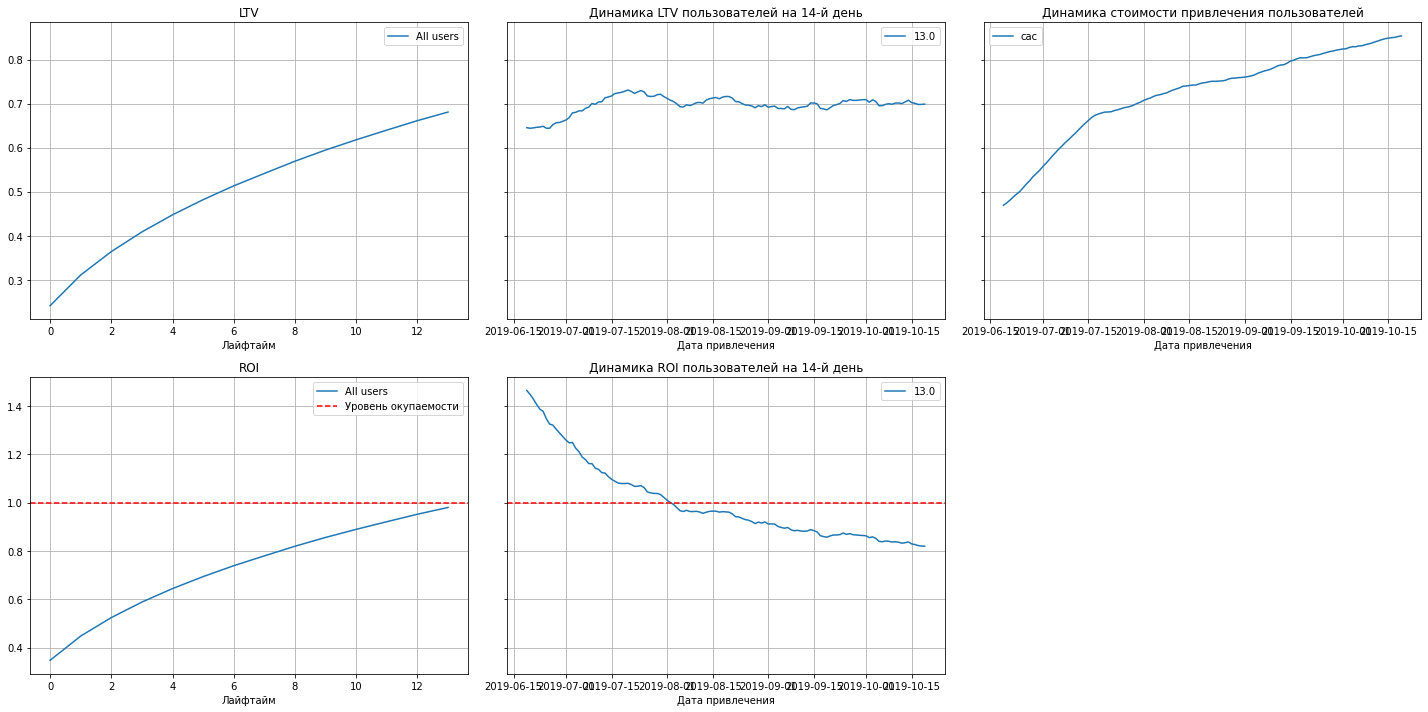

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
    )

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=50)

#### Промежуточные выводы:
* Затраты на рекламу не окупаются. ROI в конце периода — чуть ниже 100%.
* САС увеличивается, вероятно дело в увеличении рекламного бюджета.

### 5.2. Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

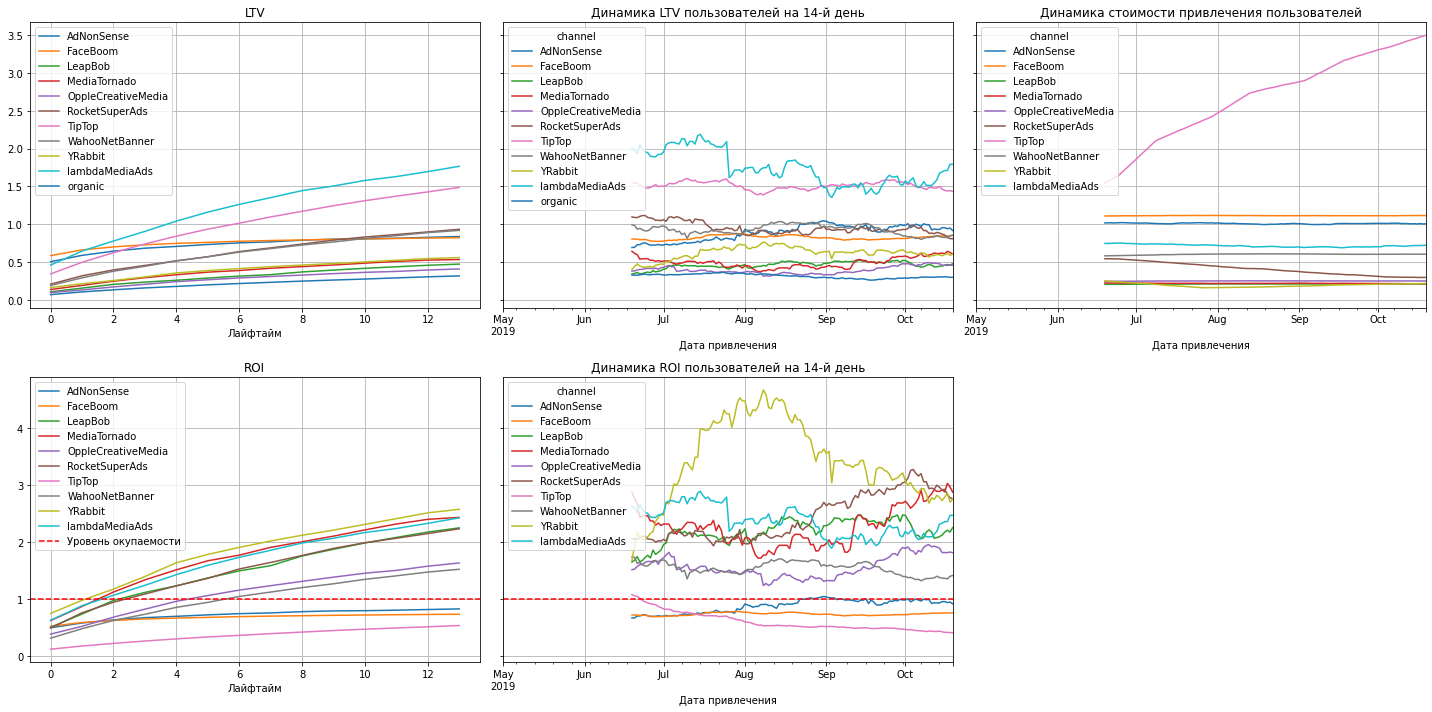

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
    )

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=50)

#### Промежуточные выводы:
* LTV достаточно стабилен.
* 3 канала привлечения пользователей не окупаются: Tip Top, FaceBoom, AdNonSense
* В динамике AdNonSense приближается к уровню окупаемости, в отличае от Tip Top и FaceBoom.
* ROI падает, так как привлечение растет.

### 5.3. Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

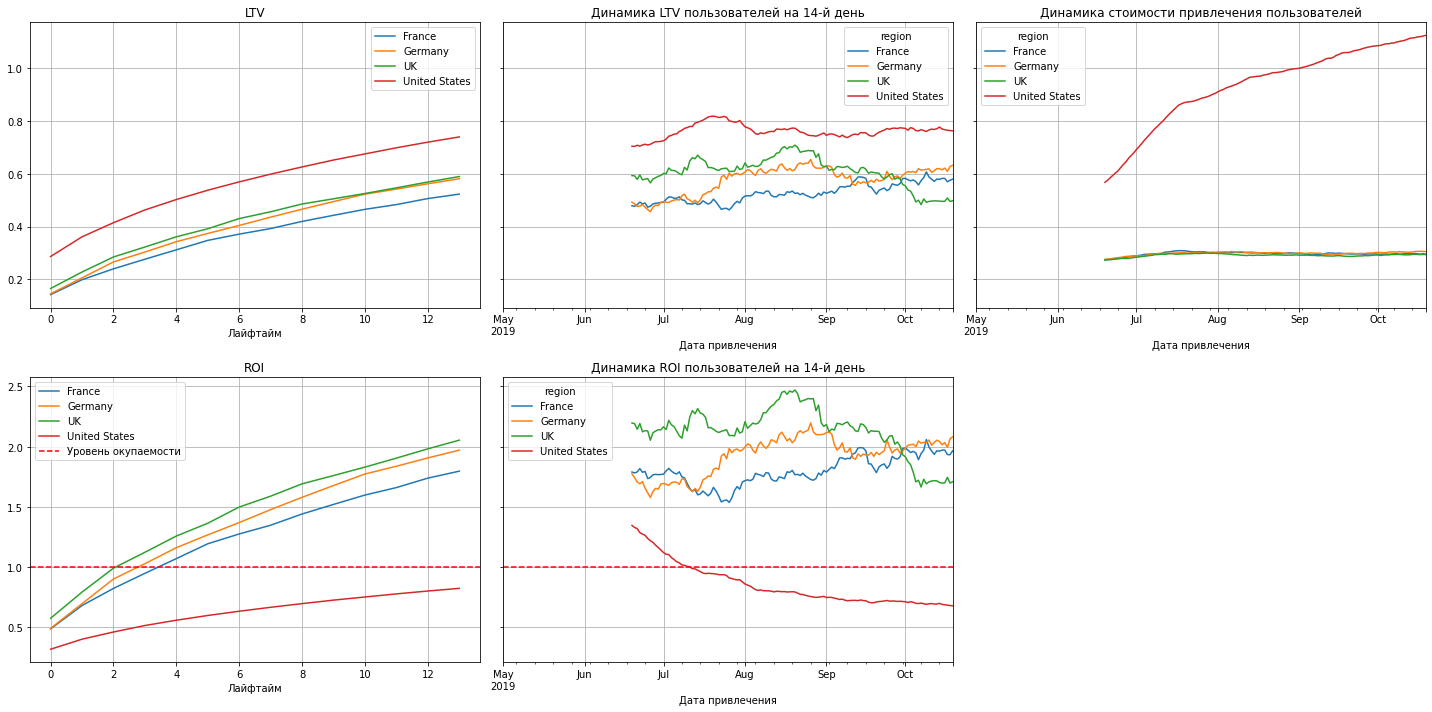

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
    )

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=50)

#### Промежуточные выводы:
* Пользователи из США не окупаются.

### 5.4. Построим и изучим графики конверсии и удержания с разбивкой по устройствам.

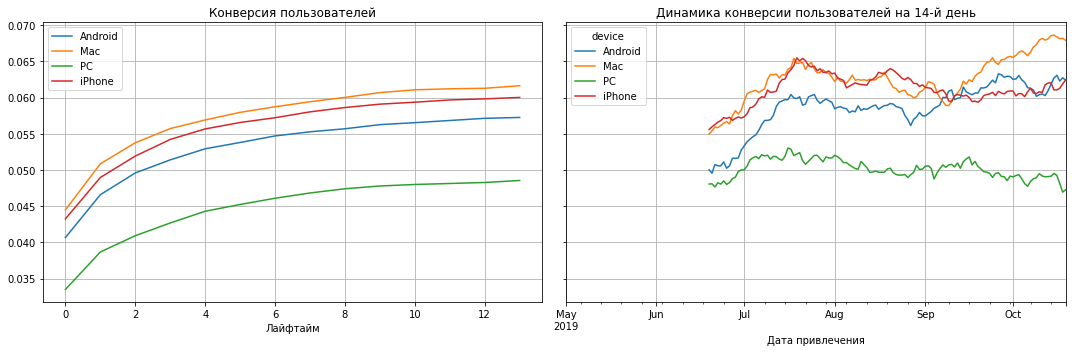

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion, conversion_history, horizon_days,  window=50)

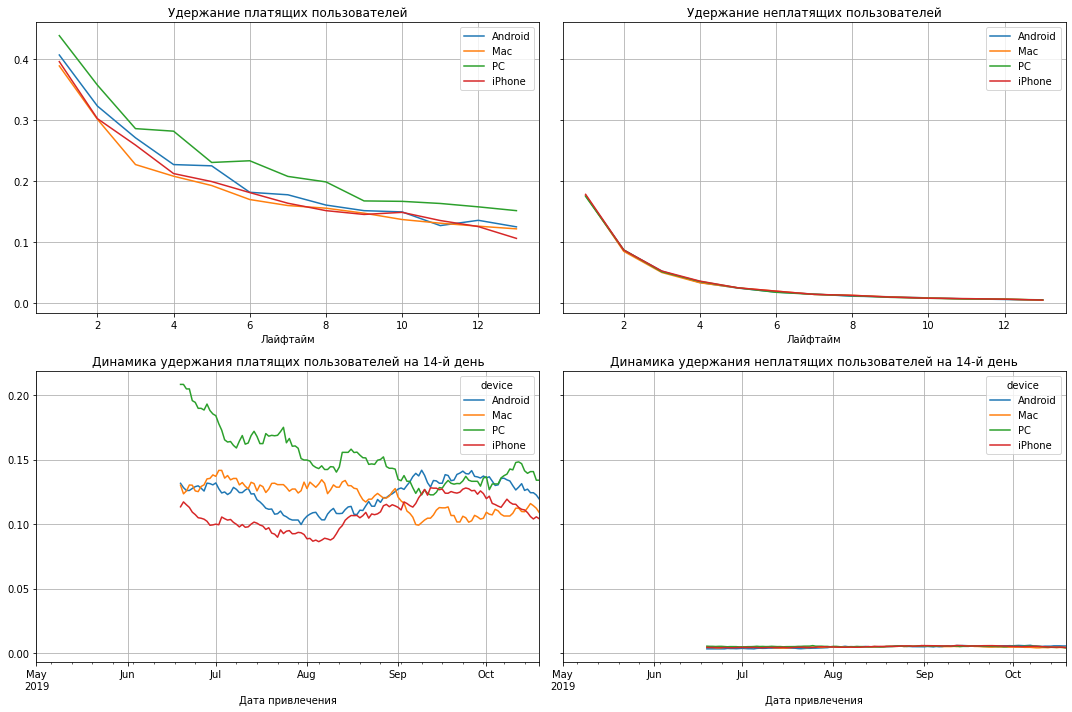

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention, retention_history, horizon_days, window=50)

#### Промежуточные выводы:
* Лучше всего удерживаются пользватели PC, но конверсия у них самая низкая. На втором месте пользовтаели Android.

### 5.5. Построим и изучим графики конверсии и удержания с разбивкой по странам.

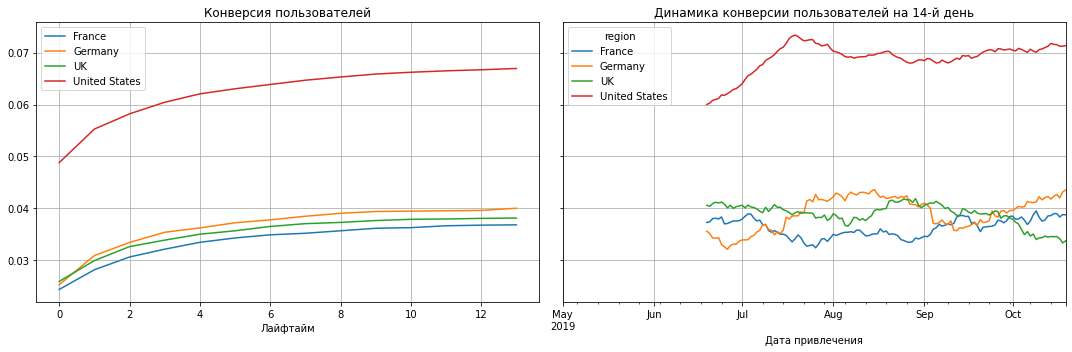

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion, conversion_history, horizon_days,  window=50)

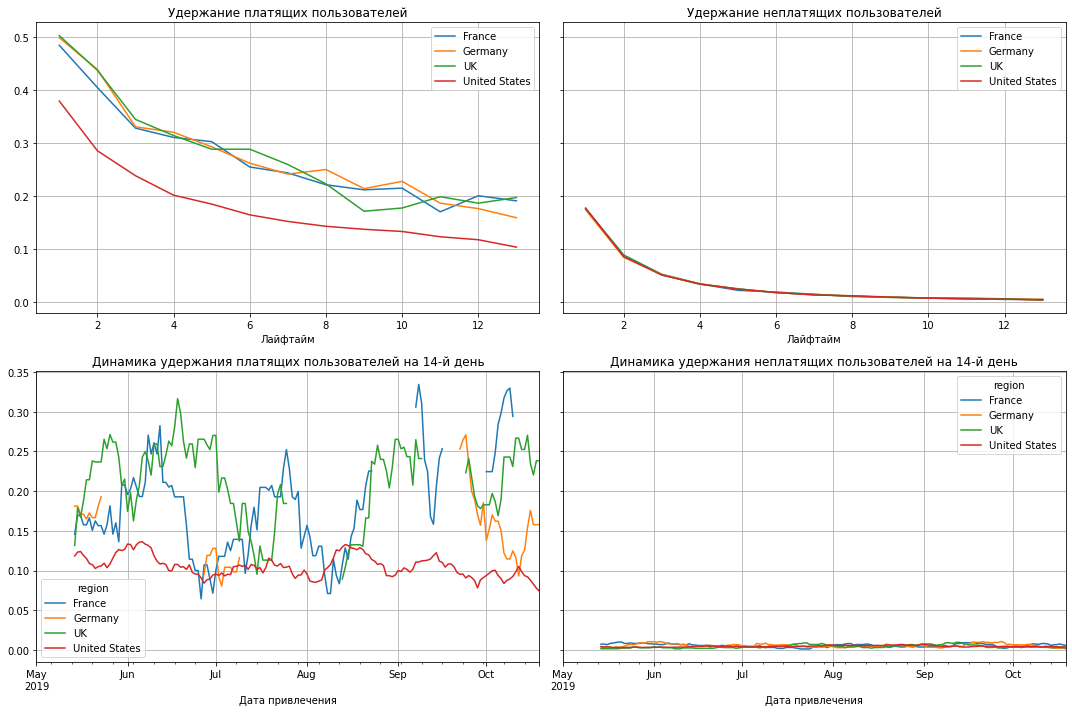

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention, retention_history, horizon_days, window=14)

#### Промежуточные выводы:
* Лучше всего конвертитруются пользователи из США, и хуже всего удерживаются тоже пользователи из США.

### 5.6. Построим и изучим графики конверсии и удержания с разбивкой по рекламным каналам.

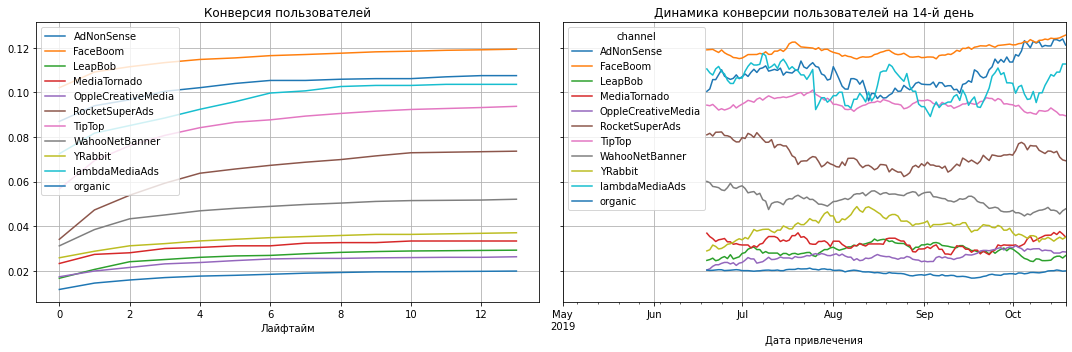

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion, conversion_history, horizon_days,  window=50)

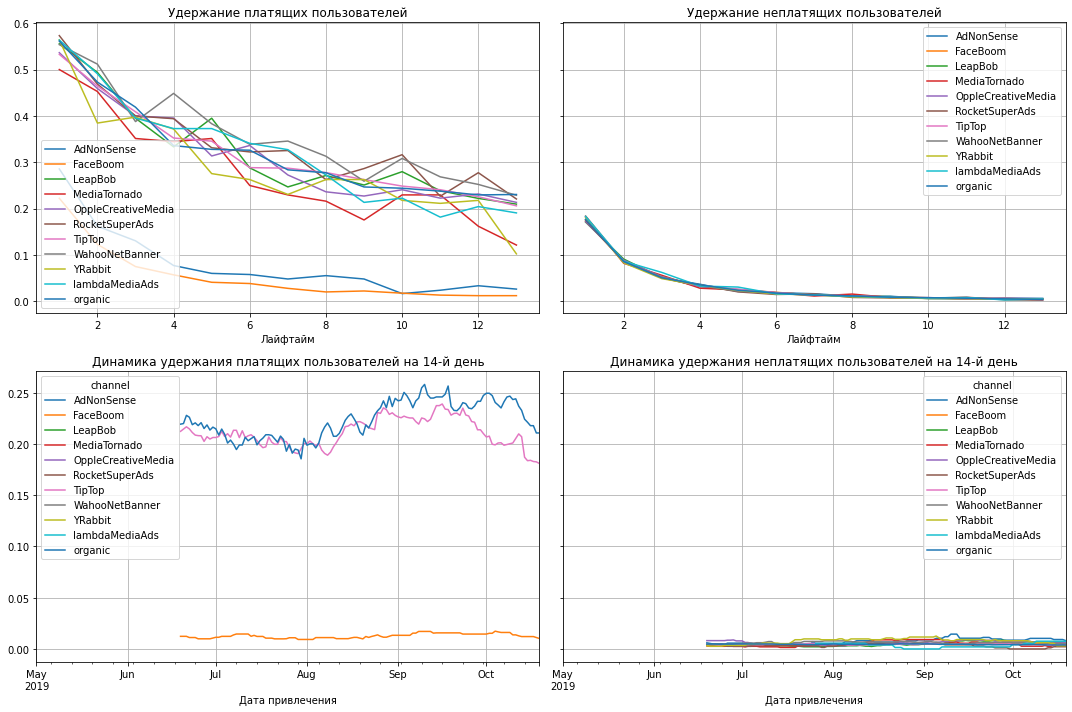

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention, retention_history, horizon_days, window=50)

#### выводы

Ответим на такие вопросы:
* Окупается ли реклама в целом? - нет
* Какие устройства, страны и каналы могут снижать окупаемость рекламы? - сильнее всего пользователи из США, так же каналы привлечения Tip Top и FaceBoom сильнее всего снижают окупаемость рекламы.
* Чем могут быть вызваны проблемы окупаемости? - пользователи FaceBoom и AdNonSense очень плохо удерживаются. Пользователи TipTop просто слишком дорогие.


## Шаг 6. Выводы

### 6.1. Выделим основные причины неэффективности привлечения пользователей.

Основная причина неэффективности - реклмный отдел. <br>
Реклама в TipTop слишком дорогая, низкое удержание пользователей FaceBoom и AdNonSense.

### 6.2. Сформулируем рекомендации для отдела маркетинга.

Рекомендую отказаться от рекламы в TipTop (потому что привлечение пользователей там слишком дорогое), так же отказаться от FaceBoom и AdNonSense (потому что пользователи слишком слабо удерживаются приходя с этих площадок).
Так же отказаться от платного привлечения пользователей из США.
Переключить внимание следует на lambdaMediaAds.